In [30]:
import numpy as np
from RBM import RBM
import torchvision.datasets as datasets
import torch
from data_cleaning import *
import time

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [15]:
size_dataset = mnist_trainset.test_data.shape[0]
v_data = mnist_trainset.train_data.reshape(size_dataset, -1).float()
v_data.size()

/home/karelgeraedts/Documents/uni/Master_Theses/code/Renormalization-Group-Bialek/.venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/karelgeraedts/Documents/uni/Master_Theses/code/Renormalization-Group-Bialek/.venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 784])

In [23]:
def normalize_data(v_data):
    # Compute standard deviations
    stds = torch.std(v_data, dim=0)

    # Find features with std = 0
    features_to_mask = torch.argwhere(stds == 0).unique()

    # Create mask
    mask = torch.ones(v_data.size()[1], dtype=bool)
    mask[features_to_mask] = False

    # Mask these features
    v_data = v_data[:, mask]
    
    # Return normalized data
    return (v_data - torch.mean(v_data, dim=0)) / torch.std(v_data, dim=0)

v_data = normalize_data(v_data)
v_data.size()

torch.Size([60000, 717])

In [58]:
# Load Ebo's dataset
f = "data/2d_Ising_metropolis_L=16,T=3.npy"
v_data = read_input(f)
v_data[v_data == - 1] = 0
v_data = torch.tensor(v_data).float()
v_data.size(), v_data.type()

(torch.Size([16384, 256]), 'torch.FloatTensor')

In [81]:
from torch.optim import Optimizer

class RBMOptimizer(Optimizer):
    def __init__(self, rbm, learning_rate=0.01, weight_decay=0, momentum=0):
        defaults = dict(learning_rate=learning_rate, weight_decay=weight_decay, momentum=momentum)
        super().__init__(rbm.parameters(), defaults)
        self.rbm = rbm

    def step(self, v_bias_update, h_bias_update, vh_weight_update):
        for group in self.param_groups:
            # Learning params
            learning_rate = group["learning_rate"]
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]

            # Update weights
            self.rbm.v_bias -= learning_rate * v_bias_update
            self.rbm.h_bias -= learning_rate * h_bias_update
            self.rbm.W -= learning_rate * vh_weight_update - weight_decay * torch.sign(self.rbm.W)

In [82]:
# RBM parrams
n_visible = v_data.shape[1]
n_hidden = 64
CD_depth = 5

# Weight update params
learning_rate = 0.001
weight_decay = 0.01
momentum = 0

# Learning params
epochs = 100
batch_size = 100

# Normalize data s.t. N(0, 1)
#v_data = normalize_data(v_data)

# Create RBM layer
rbm = RBM(n_visible, n_hidden, CD_depth)

# Optimizer
optimizer = RBMOptimizer(rbm, learning_rate=learning_rate)

# Things to keep track of
expression_to_update_weights_ = []

# Put data in a torch.DataLoader
v_dataloader = torch.utils.data.DataLoader(v_data, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for v_batch in v_dataloader:

        # Forward statistics
        # t1 = time.time()
        h_batch, _ = rbm.v_to_h(v_batch)
        vh_batch = rbm(v_batch) #NOTE: Joint-probability distribution P(v, h)

        # Reconstruction statistics (Computed using Contrastive Divergence)
        vh_recon, v_recon, h_recon = rbm.create_CD_reconstructions(v_batch, CD_depth)

        # Compute weight updates
        v_bias_update = (v_batch - v_recon).mean()
        h_bias_update = (h_batch - h_recon).mean()
        vh_weight_update = (vh_batch - vh_recon).mean()

        # Update weights
        optimizer.step(v_bias_update, h_bias_update, vh_weight_update)
        
        # Compute loss statistics
        v_recon_error = torch.mean((v_batch - v_recon) ** 2, dim=(0,1))
        h_recon_error = torch.mean((h_batch - h_recon) ** 2, dim=(0,1))
        vh_recon_error = torch.mean((vh_batch - vh_recon) ** 2, dim=(0,1))

        loss = [v_recon_error, h_recon_error, vh_recon_error]

        # print(time.time() - t1)

    # Print loss
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Reconstructions errors: {}'.format(epoch+1, epochs, loss))


Epoch [10/100], Reconstructions errors: [tensor(0.5017), tensor(0.4394), tensor(0.0033)]
Epoch [20/100], Reconstructions errors: [tensor(0.5023), tensor(0.4049), tensor(0.0023)]
Epoch [30/100], Reconstructions errors: [tensor(0.4973), tensor(0.3733), tensor(0.0022)]
Epoch [40/100], Reconstructions errors: [tensor(0.4990), tensor(0.4038), tensor(0.0022)]
Epoch [50/100], Reconstructions errors: [tensor(0.4968), tensor(0.4412), tensor(0.0019)]
Epoch [60/100], Reconstructions errors: [tensor(0.4963), tensor(0.5854), tensor(0.0014)]
Epoch [70/100], Reconstructions errors: [tensor(0.4997), tensor(0.8052), tensor(0.0005)]
Epoch [80/100], Reconstructions errors: [tensor(0.5059), tensor(0.9418), tensor(0.0002)]
Epoch [90/100], Reconstructions errors: [tensor(0.4783), tensor(0.9444), tensor(0.0003)]
Epoch [100/100], Reconstructions errors: [tensor(0.4942), tensor(0.9688), tensor(0.0002)]


In [83]:
for param in rbm.parameters():
    print(param.size())

torch.Size([256, 64])
torch.Size([256])
torch.Size([64])


tensor(-0.1338) tensor(-0.0522)


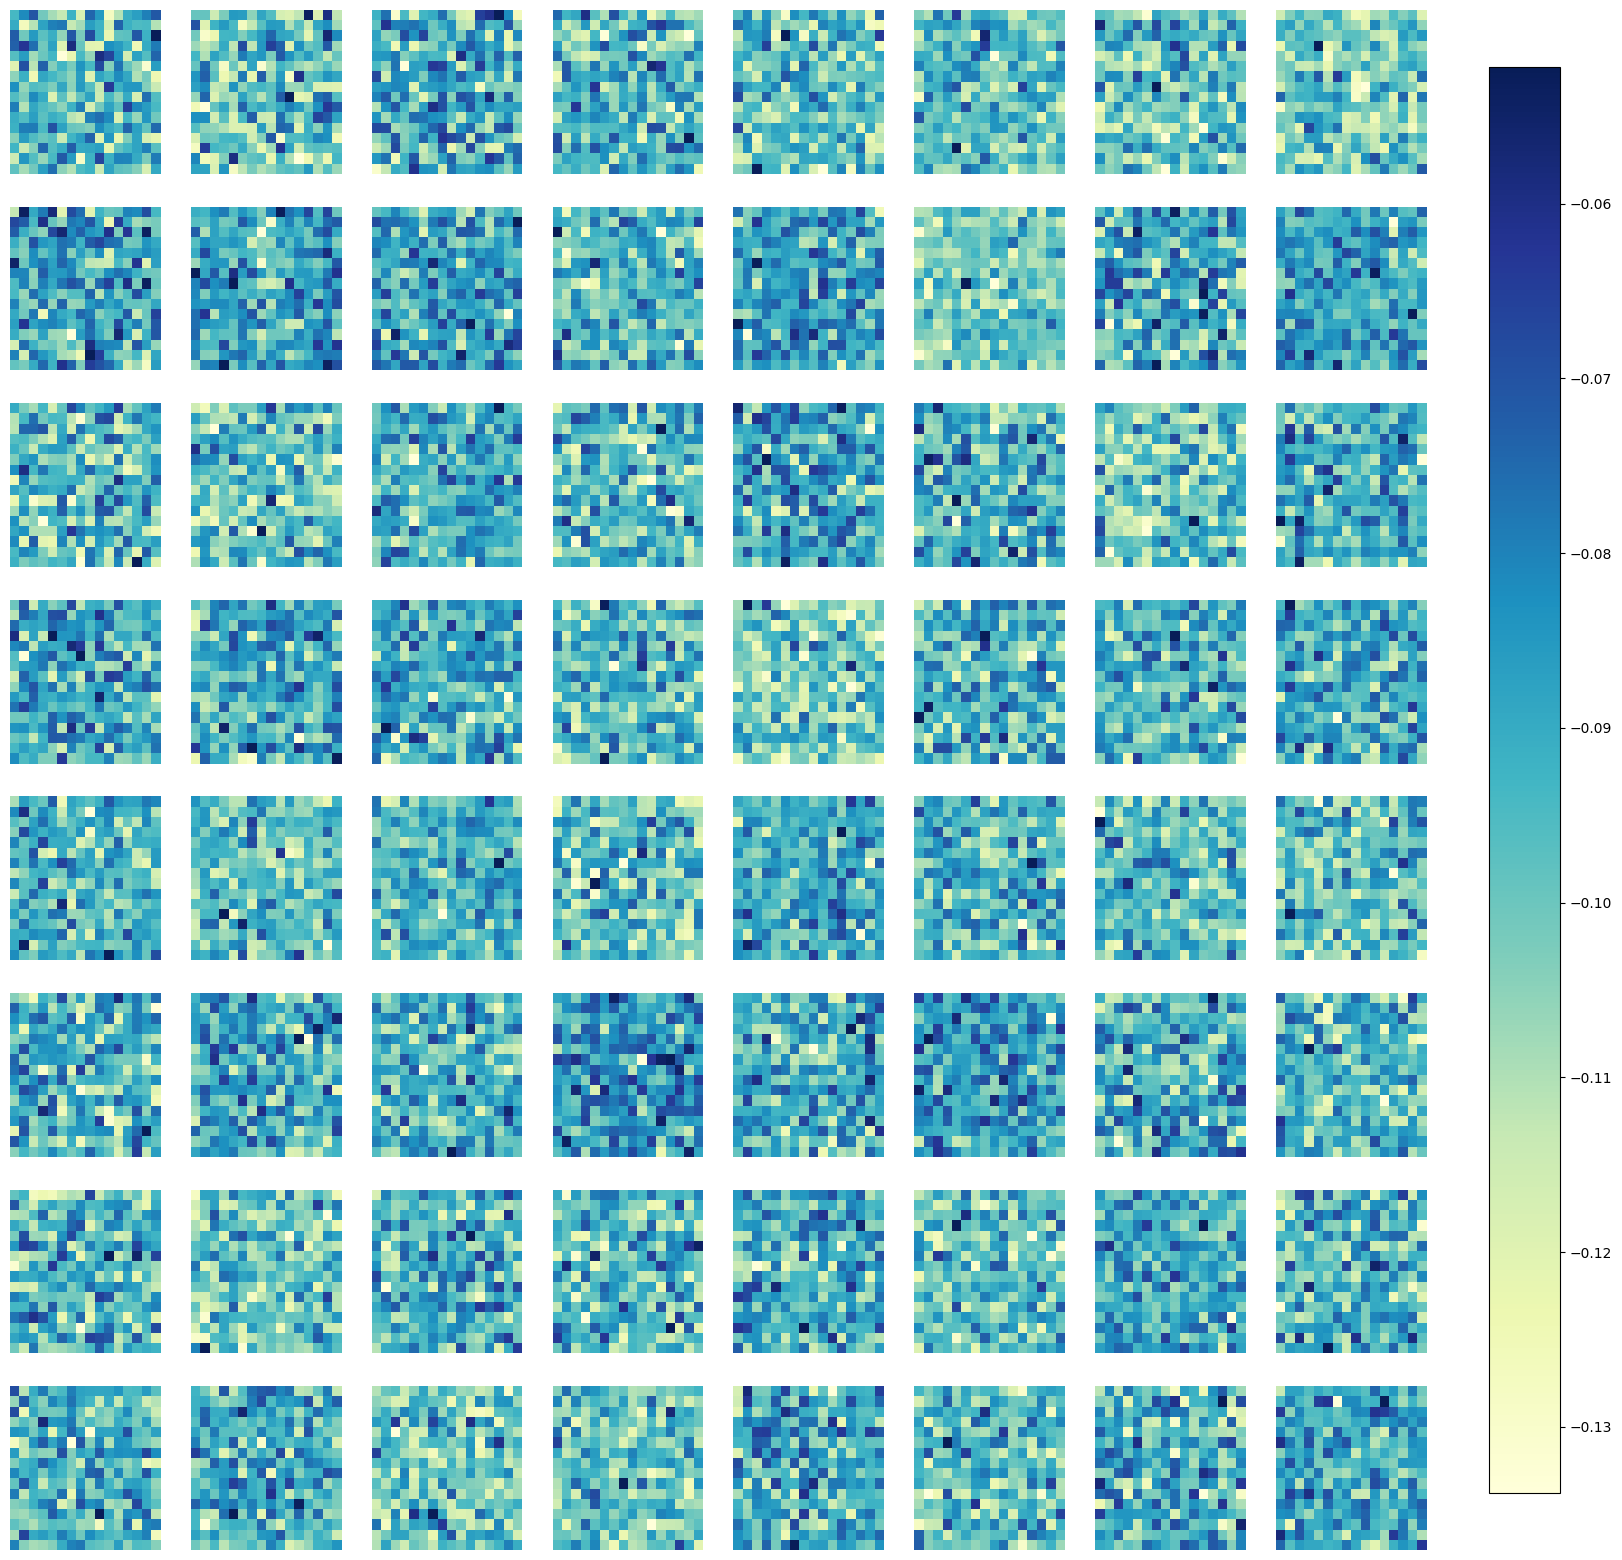

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

params = rbm.parameters()
W = list(params)[0]

# Create a figure with 8 rows and 8 columns of subplots
fig, axes = plt.subplots(8, 8, figsize=(20, 20))

# Flatten the axes array to make it 1-dimensional
axes = axes.ravel()

# Create an empty mappable object
print(W.min(), W.max())
sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=W.min(), vmax=W.max()))
sm._A = []

for i, hidden in enumerate(W.T):
    # Reshape weights
    hidden = hidden.numpy().reshape(16, 16)

    # Select the current subplot
    ax = axes[i]

    # Plot the heatmap of the weights on the current subplot
    sns.heatmap(hidden, ax=ax, cmap='YlGnBu', cbar=False, xticklabels=False, yticklabels=False)

    # Remove the axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# Add the colorbar to the figure
cbar = plt.colorbar(sm, ax=axes, fraction=0.046, pad=0.04)

# Display the figure
plt.show()